# Build a Hidden Markov Model in PyTorch
**PyTorch** is a deep learning neural networks package for Python [[Youtube - PyTorch Explained](https://www.youtube.com/watch?v=iTKbyFh-7GM)].

This is a practical project for learning Probabilistic Graphical Models (PGM). It implements the **Viterbi**, **Forward-Backward** and the **Baum Welch** algorithms.

I added my own personal enhancements (like clearer code documentation) and modifications to [this original project](https://nbviewer.jupyter.org/github/TreB1eN/HiddenMarkovModel_Pytorch/blob/master/HiddenMarkovModel.ipynb) put together by [TreB1eN](https://github.com/TreB1eN).

## Hidden Markov Model (HMM)


A Markov chain is useful when we need to compute a probability for a sequence
of observable events. In many cases, however, the events we are interested in are
hidden: we don’t observe them directly. For example we don’t normally observe
part-of-speech tags in a text. Rather, we see words, and must infer the tags from the
word sequence. [[pg 2, Dan Jurafsky, Stanford](https://web.stanford.edu/~jurafsky/slp3/A.pdf)]

In HMM the sequences are hidden because it is not possible to tell the state merely by the output symbol.

### Dynamic Programming (DP) Table
A dynamic programming table is a way of making your algorithm more efficient by storing some of the intermediate results. It's useful when your algorithm has a lot of repetitive computations. 

In [1]:
def dptable(state_prob):
    print(" ".join(("%8d" % i) for i in range(state_prob.shape[0])))
    for i, prob in enumerate(state_prob.T):
        print("%.7s: " % states[i] +" ".join("%.7s" % ("%f" % p) for p in prob))

## Viterbi Example
Here's a [Youtube video](https://www.youtube.com/watch?v=mHEKZ8jv2SY) that provides a quick and super simple example implementing the Viterbi algorithm. The Viterbi algorithm is a dynamic algo that allows us to compute the most probable path. It takes the **max** over the previous path probabilities. This package, will **recursively** compute the probability of the most probable path.

Now, let's consider a simple HMM with:
* 2 hidden states: Healthy or Fever
* 3 possible observations: Normal, Cold or Dizzy

The model can then be used to predict if a person is feverish, at every time-step, from a given observation sequence. There are several paths through the hidden states (Healthy and Fever) that lead to the given sequence, each with different paths.

In [2]:
import pandas as pd

### Model Parameters 

* **Transition probability**: 
    * A matrix with the probabilities from transitioning from one state to the next state, over time.
    * P(nextState|currentState)


* **Emission probability**: 
    * A matrix with the probabilities of an observation (output) being generated from a state.
    * P(Observation|currentState)


* **Initial probability**: 
    * A starting probability distribution over states
    * P(initialState)


* **Final probability**: A final probability distribution over states

In [3]:
import numpy as np
# A start distribution π is required; setting π = [0.6, 0.4] means a probability 0.6 of starting in state 1 (Healthy), and a  probability 0.4 of starting in state 2 (Fever)
p0 = np.array([0.6, 0.4])

transition = np.array([[0.7, 0.3],
                       [0.4, 0.6]])

emissions = np.array([[0.5, 0.1], 
              [0.4, 0.3], 
              [0.1, 0.6]])

states = {0:'Healthy', 1:'Fever'}
observations = {0:'normal', 1:'cold', 2:'dizzy'}

obs_seq = np.array([0, 0, 1, 2, 2]) # Sequence: Normal, Normal, Cold, Dizzy, Dizzy

In [4]:
import pandas as pd

## Initial state vector
We can think of the _i_th component of the vector as representing the probability that the chain starts in state $s_{i}$ 

In [5]:
df_p0 = pd.DataFrame(p0, index=["Healthy", "Fever"], columns=["Probability"])
df_p0

,Probability
Healthy,0.6
Fever,0.4


## Transition probability matrix
Let's assume that if the person is Healthy now the probability that they will be healthy the next _"time"_ is 70%. So that leaves a 30% chance that the person will be Feverish the next _"time"_. 

Let's assume that if the person is Feverish now, there's a 40% chance that they'll become Healthy next _"time"_ and a 60% chance that they'll remain feverish next _"time"_.

In [6]:
df_transition = pd.DataFrame(transition, index=["fromHealthy", "fromFever"], columns=["toHealthy", "toFever"])
df_transition

,toHealthy,toFever
fromHealthy,0.7,0.3
fromFever,0.4,0.6


## Emission probability marix (Observation)
Let's say that we have concluded that when a person is Healthy there's a 50% chance that they are Normal, a 40% chance that they are Cold, and a 10% chance that they are Dizzy.

Let's say that we also concluded that when a person is Feverish there's a small 10% chance they are Normal, a 30% chance that they are Cold, and a much larger 60% chance that they are Dizzy.

In [7]:
df_emissions = pd.DataFrame(emissions, index=["Normal", "Cold", "Dizzy"], columns=["Healthy", "Fever"])
df_emissions

,Healthy,Fever
Normal,0.5,0.1
Cold,0.4,0.3
Dizzy,0.1,0.6


## Run Viterbi
Calculate the Viterbi path, which is the most likely sequence of states that generated the sequence given the full model

In [8]:
from HiddenMarkovModel import HiddenMarkovModel # Don't forget to add the local file HiddenMarkovModel.py to your present working directory

In [9]:
model = HiddenMarkovModel(transition, emissions, p0) # Define the HMM

states_seq, state_prob = model.viterbi_inference(obs_seq) # Calculate the Viterbi path

In [10]:
print("Observation sequences: ", [observations[o] for o in obs_seq])

Observation sequences:  ['normal', 'normal', 'cold', 'dizzy', 'dizzy']


In [11]:
import torch

# Transpose the state probability matrix. Move the tensor to cpu(). Convert torch tensor to numpy array. 
df = pd.DataFrame(torch.t(state_prob).cpu().numpy(), index=["Health", "Fever"])

def highlight_max(s):
    '''
    Highlight the maximum in a series in yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Display the tensor
df.style.apply(highlight_max, axis=0)

,0,1,2,3,4
Health,0.3,0.105,0.0294,0.002058,0.00021168
Fever,0.04,0.009,0.00945,0.005292,0.00190512


In [12]:
print("The most likely states are: ", [states[s.item()] for s in states_seq])

The most likely states are:  ['Healthy', 'Healthy', 'Healthy', 'Fever', 'Fever']


## Forward-Backward Algorithm (Unsupervised)
Unlike the part-of-speech tagger (supervised) that has a corpus of labeled words, many applications **don’t** have labeled data so instead we can use the Forward-Backward algorithm (an unsupervised algorithm).

The real problem is we don’t know the counts of being in any of the hidden states! The Baum-Welch algorithm solves this by iteratively estimating the counts. We will start with an estimate for the transition and observation probabilities and then use these estimated probabilities to derive better and better
probabilities. And we’re going to do this by computing the forward probability for an observation and then dividing that probability mass among all the different paths that contributed to this forward probability. [[Pg. 11, Jurafsky](https://web.stanford.edu/~jurafsky/slp3/A.pdf)]

**Overview**
* The goal of the forward-backward algorithm is to find the conditional distribution over hidden states given the data.
* It is used to find the most likely state for any point in time.
* It cannot, however, be used to find the most likely sequence of states (see Viterbi)
* The algorithm makes use of the principle of dynamic programming to compute efficiently the values that are required to obtain the posterior marginal distributions in two passes.
* The first pass goes forward in time while the second goes backward in time.

[[Youtube explanation](https://www.youtube.com/watch?v=9yl4XGp5OEg)] of the algorithm.


## Forward-Backward Example
Let's consider a situation where you work in a shopping mall with no views to the outside. And you want to infer the weather outside **(Rain, No Rain)** at the present moment, given only observations of passerby **with or without an umbrella**.

### Define Model Parameters

In [25]:
p0 = np.array([0.5, 0.5])

emi = np.array([[0.9, 0.2],
                [0.1, 0.8]])

trans = np.array([[0.7, 0.3],
                  [0.3, 0.7]])

states = {0:'rain', 1:'no_rain'}
obs = {0:'umbrella', 1:'no_umbrella'}

obs_seq = np.array([1, 1, 0, 0, 0, 1])

In [26]:
print("Observation sequence: ", [obs[o] for o in obs_seq])

Observation sequence:  ['no_umbrella', 'no_umbrella', 'umbrella', 'umbrella', 'umbrella', 'no_umbrella']


### Run Forward-Backward

In [14]:
model =  HiddenMarkovModel(trans, emi, p0)

In [15]:
model.N = len(obs_seq)

# As defined in the module, Model.S = Number of possible states
shape = [model.N, model.S] # [6, 2]

In [16]:
model.initialize_forw_back_variables(shape) # Creates the "forward", "backward" and "posterior" tensor's each filled with 0's, each with shape [6,2] 

In [17]:
obs_prob_seq = model.E[obs_seq] # Emission probability matrix
obs_prob_seq

tensor([[0.1000, 0.8000],
        [0.1000, 0.8000],
        [0.9000, 0.2000],
        [0.9000, 0.2000],
        [0.9000, 0.2000],
        [0.1000, 0.8000]], dtype=torch.float64)

In [18]:
model.forward_backward(obs_prob_seq) # runs the forward backward algorithm on observation sequence

In [19]:
posterior = model.forward * model.backward

In [20]:
# marginal per timestep
marginal = torch.sum(posterior, 1)
marginal

tensor([2.2222, 1.7893, 2.3405, 1.6626, 1.5378, 2.9350], dtype=torch.float64)

In [21]:
# Normalize porsterior into probabilities
posterior = posterior / marginal.view(-1, 1) 
posterior

tensor([[0.0703, 0.9297],
        [0.1115, 0.8885],
        [0.7970, 0.2030],
        [0.8936, 0.1064],
        [0.8100, 0.1900],
        [0.1926, 0.8074]], dtype=torch.float64)

In [22]:
results = [model.forward.cpu().numpy(), model.backward.cpu().numpy(), posterior.cpu().numpy()]
result_list = ["Forward", "Backward", "Posterior"]
results

[array([[0.11111111, 0.88888889],
        [0.06163022, 0.93836978],
        [0.68386767, 0.31613233],
        [0.85819949, 0.14180051],
        [0.89028987, 0.10971013],
        [0.19256815, 0.80743185]]), array([[1.40699516, 2.32412561],
        [3.23616294, 1.69423506],
        [2.72775586, 1.50282191],
        [1.73108003, 1.24784833],
        [1.39911871, 2.66283883],
        [2.93497129, 2.93497129]]), array([[0.07034976, 0.92965024],
        [0.11146783, 0.88853217],
        [0.79701447, 0.20298553],
        [0.89357028, 0.10642972],
        [0.81002232, 0.18997768],
        [0.19256815, 0.80743185]])]

In [23]:

for state_prob, path in zip(results, result_list) :
    inferred_states = np.argmax(state_prob, axis=1) # Returns the indices of the maximum values along axis 1
    print()
    print(path)
    dptable(state_prob)
    print()

print("="*60)
print("Most likely Final State: ",states[inferred_states[-1]])
print("="*60)


Forward
       0        1        2        3        4        5
rain: 0.11111 0.06163 0.68386 0.85819 0.89029 0.19256
no_rain: 0.88888 0.93837 0.31613 0.14180 0.10971 0.80743


Backward
       0        1        2        3        4        5
rain: 1.40699 3.23616 2.72775 1.73108 1.39911 2.93497
no_rain: 2.32412 1.69423 1.50282 1.24784 2.66283 2.93497


Posterior
       0        1        2        3        4        5
rain: 0.07035 0.11146 0.79701 0.89357 0.81002 0.19256
no_rain: 0.92965 0.88853 0.20298 0.10643 0.18997 0.80743

Most likely Final State:  no_rain


# Baum Welch Algorithm
Baum–Welch algorithm is used to infer unknown parameters of a Hidden Markov Model.

**Expectation-Maximization (EM)**
It makes use of the forward-backward algorithm to update the hypothesis.

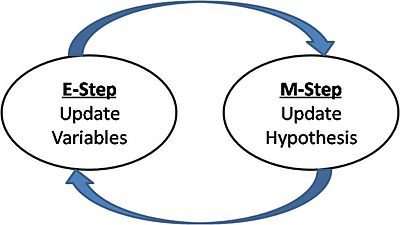

**Note**:
* It is possible to over-fit a particular data set. That is P(Y|θfinal)>P(Y|θtrue).
* The algorithm also does not guarantee a global maximum.

## Run Baum-Welch
### Data Generator Function

In [27]:
def generate_HMM_observation(num_obs, pi, T, E):
    def drawFrom(probs):
        return np.where(np.random.multinomial(1,probs) == 1)[0][0]

    obs = np.zeros(num_obs)
    states = np.zeros(num_obs)
    states[0] = drawFrom(pi)
    obs[0] = drawFrom(E[:, int(states[0])])
    for t in range(1,num_obs):
        states[t] = drawFrom(T[int(states[t-1]),:])
        obs[t] = drawFrom(E[:, int(states[t])])
    return np.int64(obs), states

### True Parameters that Generated the data

In [28]:
True_pi = np.array([0.5, 0.5])

True_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

True_E = np.array([[0.8, 0.0],
                   [0.1, 0.0],
                   [0.1, 1.0]])

### Generate a Sample of 50 Observations

In [29]:
obs_seq, states = generate_HMM_observation(200, True_pi, True_T, True_E)

In [30]:
print("First 10 Obersvations:  ", obs_seq[:10])
print("First 10 Hidden States: ", states[:10])

First 10 Obersvations:   [0 0 2 0 0 0 0 0 1 0]
First 10 Hidden States:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Initialize to Arbitrary Parameters¶

In [31]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.5, 0.5],
                  [0.5, 0.5]])

init_E = np.array([[0.3, 0.2],
                   [0.3, 0.5],
                   [0.4, 0.3]])

### Train Model

In [32]:
model =  HiddenMarkovModel(init_T, init_E, init_pi, epsilon=0.0001, maxStep=100)

In [33]:
trans0, transition, emission, converge = model.Baum_Welch_EM(obs_seq)

print("Transition Matrix: ")
print(transition)
print()
print("Emission Matrix: ")
print(emission)
print()
print("Reached Convergence: ")
print(converge)

converged at step 60
Transition Matrix: 
tensor([[0.7785, 0.2215],
        [0.1027, 0.8973]], dtype=torch.float64)

Emission Matrix: 
tensor([[8.4097e-01, 1.0325e-04],
        [9.9798e-02, 2.2171e-13],
        [5.9236e-02, 9.9990e-01]], dtype=torch.float64)

Reached Convergence: 
True


### Plot of Probability of State 1 Over Multiple Training Steps

In [34]:
state_summary = np.array([model.prob_state_1[i].cpu().numpy() for i in range(len(model.prob_state_1))])

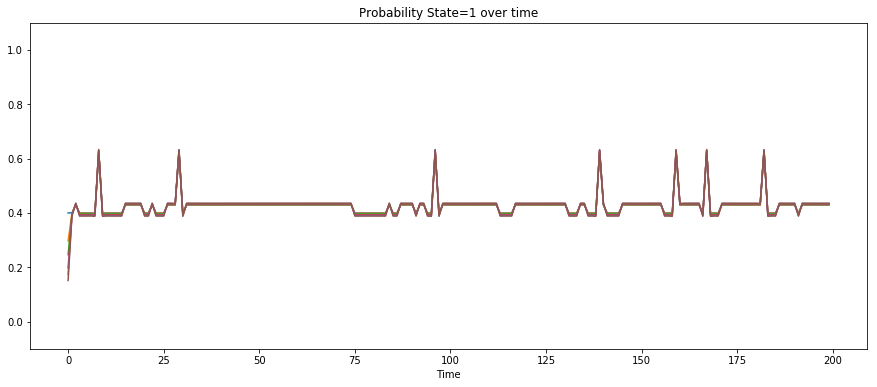

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,6))
plt.plot(1 - state_summary[[0, 4, 6, 8, 9, 10]].T)
plt.ylim(-0.1,1.1)
plt.title('Probability State=1 over time')
plt.xlabel('Time')
plt.draw()

### Plot of True State over Guess Probability of State=1

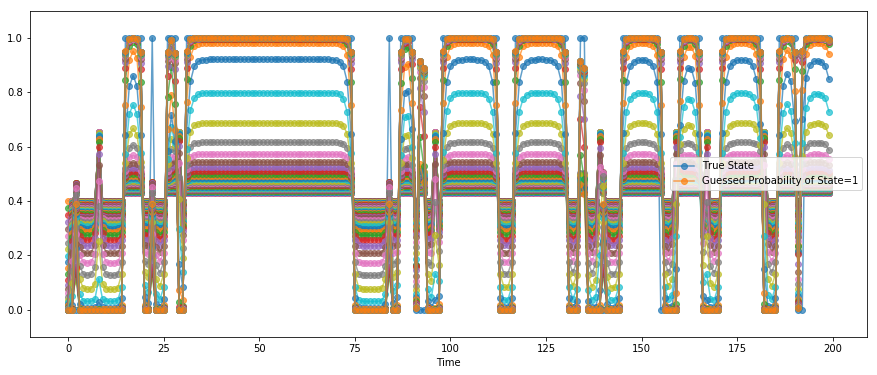

In [36]:
plt.figure(figsize=(15,6))
plt.plot(states.T,'-o',alpha=0.7)
plt.plot(1 - state_summary.T, '-o',alpha=0.7)
plt.legend(('True State','Guessed Probability of State=1'), loc = 'right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()

### Beware of Overfitting
The algorithm is clearly learning to generate the correct hidden state.
Baum Welch does, however, overfit quickly.
It is important to:
Train on multiple sequences.
Regularize training.
Repeat inference with multiple random initial parameters.

In [37]:
pred = (1 - state_summary[-2]) > 0.5
print("Accuracy: ", np.mean(pred == states))

Accuracy:  0.97
